# Modeling connected wells with the WellString element

A WellString can be used to model a series of connected wells. There are several types of
WellString:

- `WellString`: connected wells with equal head inside the wells and a user-specified total discharge
- `HeadWellString`: connected wells with equal specified head inside the wells, this is identical to specifying multiple HeadWells.
- `TargetHeadWellString`: connected wells with equal head inside the wells and one user-specified head at a point $(x_c, y_c)$

This notebook shows how to model the `WellString` and `TargetHeadWellString` elements
and compares the results to models with individual wells. Examples are shown for both
elements in single- and multi-layer models.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import timml as tml

## WellString

A series of wells that have equal head (pressure) inside the well and pump with a total specfied discharge.

### Single layer model

In [2]:
# model parameters
kh = 10  # m/day

ctop = 1000.0  # resistance top leaky layer in days

ztop = 0.0  # surface elevation
zbot = -20.0  # bottom elevation of the model

z = [1.0, ztop, zbot]
kaq = np.array([kh])
c = np.array([ctop])

Reference model with 2 wells with equal discharge

In [3]:
mlref0 = tml.ModelMaq(kaq=kaq, c=c, z=z, topboundary="semi", hstar=0)
w1 = tml.Well(mlref0, 0, -10, Qw=50, rw=0.1)
w2 = tml.Well(mlref0, 0, 10, Qw=50, rw=0.1)
mlref0.solve()

Reference model with 2 head-specified wells, specifying the head inside well `w1` computed with the previous model.

In [4]:
mlref1 = tml.ModelMaq(kaq=kaq, c=c, z=z, topboundary="semi", hstar=0)
wh1 = tml.HeadWell(mlref1, 0, -10, hw=w1.headinside().item(), rw=0.1)
wh2 = tml.HeadWell(mlref1, 0, 10, hw=w1.headinside().item(), rw=0.1)
mlref1.solve()

Number of elements, Number of equations: 3 , 2
..
solution complete


Model with a WellString that has total discharge equal to the sum of the two discharge-specified wells.

In [5]:
ml0 = tml.ModelMaq(kaq=kaq, c=c, z=z, topboundary="semi", hstar=0)
ws = tml.WellString(ml0, xy=[(0, -10), (0, 10)], Qw=100, rw=0.1)
ml0.solve()

Number of elements, Number of equations: 2 , 2
.
solution complete


Contour the heads of the first reference model and the WellString model.

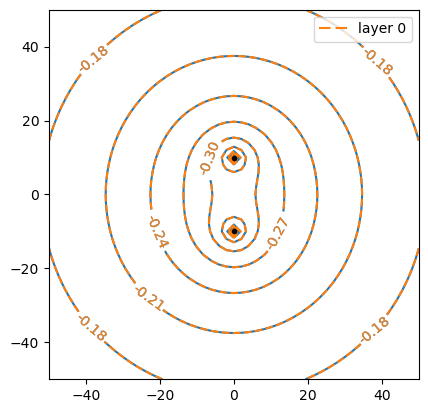

In [6]:
levels = 10
mlref0.plots.contour(
    win=(-50, 50, -50, 50), ngr=51, levels=levels, decimals=2, layers=[0]
)
ml0.plots.contour(
    win=(-50, 50, -50, 50),
    ngr=51,
    levels=levels,
    decimals=2,
    layers=[0],
    newfig=False,
    linestyles="dashed",
    color="C1",
);

Compare heads along y between all 3 models (2 reference models and the WellString model).

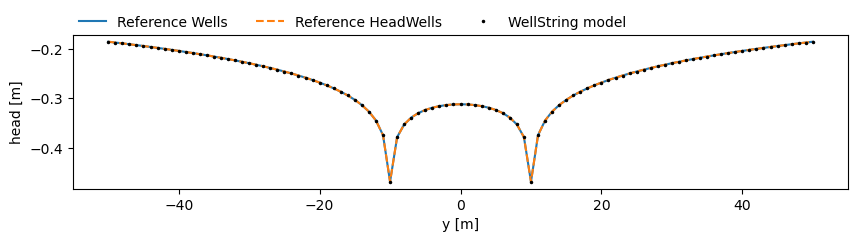

In [7]:
y = np.linspace(-50, 50, 101)
x = np.zeros_like(y)
href = mlref0.headalongline(x, y)
href2 = mlref1.headalongline(x, y)
h0 = ml0.headalongline(x, y)

plt.figure(figsize=(10, 2))
plt.plot(y, href[0], label="Reference Wells")
plt.plot(y, href2[0], "--", label="Reference HeadWells")
plt.plot(y, h0[0], "k.", ms=3, label="WellString model")
plt.xlabel("y [m]")
plt.ylabel("head [m]")
plt.legend(loc=(0, 1), frameon=False, ncol=3);

Check computed discharges

In [8]:
# 2 discharge wells, Q specified not computed
w1.discharge(), w2.discharge()

(array([50.]), array([50.]))

In [9]:
# 2 HeadWells
wh1.discharge(), wh2.discharge()

(array([50.]), array([50.]))

In [10]:
# WellString
ws.discharge_per_well()

array([[50., 50.]])

Compare heads inside the wells

In [11]:
# 2 discharge wells
w1.headinside(), w2.headinside()

(array([-0.46739383]), array([-0.46739383]))

In [12]:
# 2 HeadWells, specified, not computed
wh1.headinside(), wh2.headinside()

(array([-0.46739383]), array([-0.46739383]))

In [13]:
# WellString
ws.headinside(), ws.wlist[0].headinside(), ws.wlist[1].headinside()

(np.float64(-0.46739382577163896), array([-0.46739383]), array([-0.46739383]))

### Multilayer example

The following example compares the WellString element to reference models with
individual Wells and HeadWells in an aquifersystem consisting of 3 layers. In this example, all wells are screened in the bottom two aquifers. 

In [14]:
# model parameters
kh = [5, 10, 20]  # m/day

c = [1000.0, 100.0, 1.0]  # resistance leaky layers in days

ztop = 0.0  # surface elevation
zbot = -50.0  # bottom elevation of the model

z = [1.0, ztop, -10, -15, -25, -26, zbot]
kaq = np.array(kh)
c = np.array(c)

Reference model with discharge wells

In [15]:
mlref2 = tml.ModelMaq(kaq=kaq, c=c, z=z, topboundary="semi", hstar=0)
w1 = tml.Well(mlref2, 0, -10, Qw=50, rw=0.1, layers=[1, 2])
w2 = tml.Well(mlref2, 0, 10, Qw=50, rw=0.1, layers=[1, 2])
mlref2.solve()

Number of elements, Number of equations: 3 , 4
..
solution complete


Reference model with head-specified wells

In [16]:
mlref3 = tml.ModelMaq(kaq=kaq, c=c, z=z, topboundary="semi", hstar=0)
wh1 = tml.HeadWell(mlref3, 0, -10, hw=w1.headinside(), rw=0.1, layers=[1, 2])
wh2 = tml.HeadWell(mlref3, 0, 10, hw=w1.headinside(), rw=0.1, layers=[1, 2])
mlref3.solve()

Number of elements, Number of equations: 3 , 4
..
solution complete


Model with WellString

In [17]:
ml1 = tml.ModelMaq(kaq=kaq, c=c, z=z, topboundary="semi", hstar=0)
ws = tml.WellString(ml1, xy=[(0, -10), (0, 10)], Qw=100, rw=0.1, layers=[1, 2])
ml1.solve()

Number of elements, Number of equations: 2 , 4
.
solution complete


Compare head contours

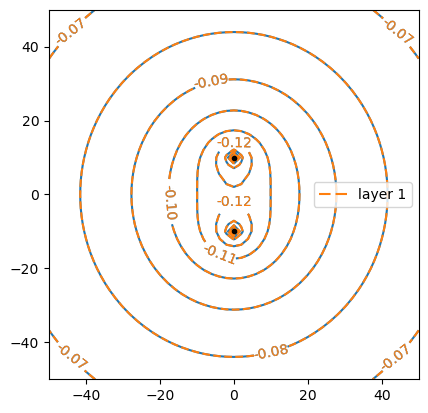

In [18]:
ilay = 1
levels = 10
mlref2.plots.contour(
    win=(-50, 50, -50, 50),
    ngr=51,
    levels=levels,
    decimals=2,
    layers=[ilay],
)
ml1.plots.contour(
    win=(-50, 50, -50, 50),
    ngr=51,
    levels=levels,
    decimals=2,
    layers=[ilay],
    newfig=False,
    linestyles="dashed",
    color="C1",
);

Compare drawdowns along y

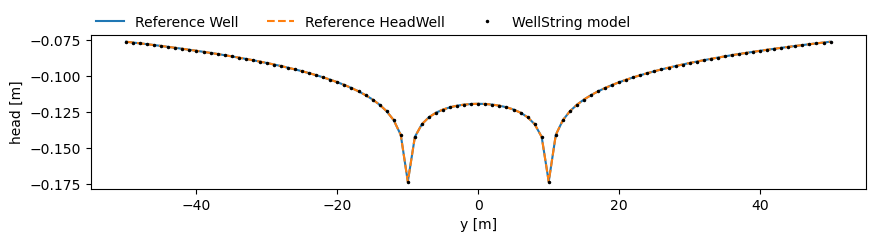

In [19]:
y = np.linspace(-50, 50, 101)
x = np.zeros_like(y)
href2 = mlref2.headalongline(x, y)
href3 = mlref3.headalongline(x, y)
h1 = ml1.headalongline(x, y)

ilay = 1
plt.figure(figsize=(10, 2))
plt.plot(y, href2[ilay], label="Reference Well")
plt.plot(y, href3[ilay], "--", label="Reference HeadWell")
plt.plot(y, h1[ilay], "k.", ms=3, label="WellString model")
plt.xlabel("y [m]")
plt.ylabel("head [m]")
plt.legend(loc=(0, 1), frameon=False, ncol=3);

Compare discharges

In [20]:
# 2 discharge wells, total Q specified
w1.discharge(), w2.discharge()

(array([ 0.        ,  8.66671446, 41.33328554]),
 array([ 0.        ,  8.66671446, 41.33328554]))

In [21]:
# 2 head specified wells
wh1.discharge(), wh2.discharge()

(array([ 0.        ,  8.66671446, 41.33328554]),
 array([ 0.        ,  8.66671446, 41.33328554]))

In [22]:
# WellString, transposed to compare to above
ws.discharge_per_well().T

array([[ 0.        ,  8.66671446, 41.33328554],
       [ 0.        ,  8.66671446, 41.33328554]])

Compare heads

In [23]:
# 2 discharge wells
w1.headinside(), w2.headinside()

(array([-0.17338765, -0.17338765]), array([-0.17338765, -0.17338765]))

In [24]:
# 2 HeadWells, specified, not computed
wh1.headinside(), wh2.headinside()

(array([-0.17338765, -0.17338765]), array([-0.17338765, -0.17338765]))

In [25]:
ws.headinside(), ws.wlist[0].headinside(), ws.wlist[1].headinside()

(np.float64(-0.17338765212543716),
 array([-0.17338765, -0.17338765]),
 array([-0.17338765, -0.17338765]))

## TargetHeadWellString

A series of connected wells with equal head (pressure) inside all wells and a specified
head at one point $(x_c, y_c)$ and layer. By default the specified head is applied in layer
0, but this can be set with `lcp=<layer>`in the `TargetHeadWellString` element.

### Single layer model

In [26]:
# model parameters
kh = 10  # m/day

ctop = 1000.0  # resistance top leaky layer in days

ztop = 0.0  # surface elevation
zbot = -20.0  # bottom elevation of the model

z = [1.0, ztop, zbot]
kaq = np.array([kh])
c = np.array([ctop])

# point at which head is specified
xcp = 10.0
ycp = 0.0
hcp = -2.0  # specified head at (xc, yc)

Build a single layer model with two `TargetHeadWells`.

_Note: we need to nudge the control point for one of the wells here to avoid a singular
matrix for solving the system._

In [27]:
mlref4 = tml.ModelMaq(kaq=kaq, c=c, z=z, topboundary="semi", hstar=0)
wh1 = tml.TargetHeadWell(mlref4, 0, -10, rw=0.1, hcp=hcp, xcp=xcp, ycp=ycp)
wh2 = tml.TargetHeadWell(
    model=mlref4,
    xw=0,
    yw=10,
    rw=0.1,
    hcp=hcp,
    xcp=xcp,
    ycp=ycp - 1e-6,  # nudge control pt
)
mlref4.solve()

Number of elements, Number of equations: 3 , 2
..
solution complete


Create model with a `TargetHeadWellString`.

In [28]:
ml2 = tml.ModelMaq(kaq=kaq, c=c, z=z, topboundary="semi", hstar=0)
ws = tml.TargetHeadWellString(ml2, [(0, -10), (0, 10)], rw=0.1, hcp=hcp, xcp=10, ycp=0)
ml2.solve()

Number of elements, Number of equations: 2 , 2
.
solution complete


Plot the head contours for both models.

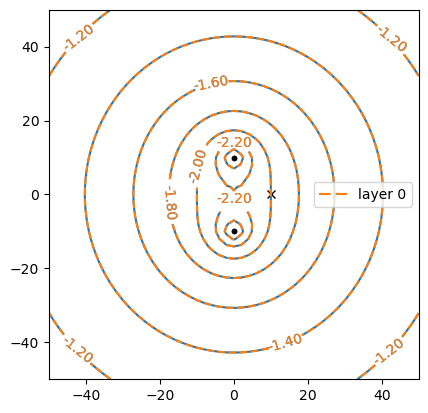

In [29]:
ilay = 0
levels = [-2.4, -2.2, -2.0, -1.8, -1.6, -1.4, -1.2]
mlref4.plots.contour(
    win=(-50, 50, -50, 50),
    ngr=51,
    levels=levels,
    decimals=2,
    layers=[ilay],
)
plt.plot(wh1.xcp, wh1.ycp, "kx")
ml2.plots.contour(
    win=(-50, 50, -50, 50),
    ngr=51,
    levels=levels,
    decimals=2,
    layers=[ilay],
    newfig=False,
    linestyles="dashed",
    color="C1",
);

Plot the heads along y for both models.

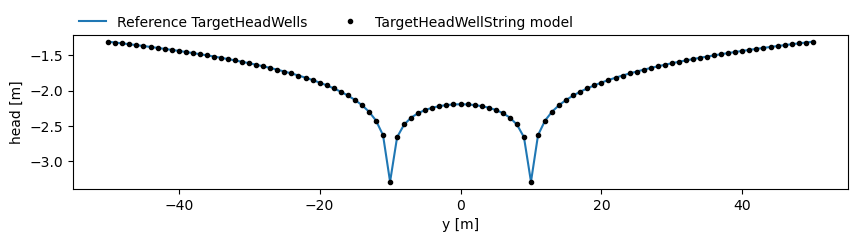

In [30]:
y = np.linspace(-50, 50, 101)
x = np.zeros_like(y)
href = mlref4.headalongline(x, y)
h2 = ml2.headalongline(x, y)

ilay = 0
plt.figure(figsize=(10, 2))
plt.plot(y, href[ilay], label="Reference TargetHeadWells")
plt.plot(y, h2[ilay], "k.", label="TargetHeadWellString model")
plt.ylabel("head [m]")
plt.xlabel("y [m]")
plt.legend(loc=(0, 1), frameon=False, ncol=2);

Plot the head along y at x=10, to show that the specified head is met

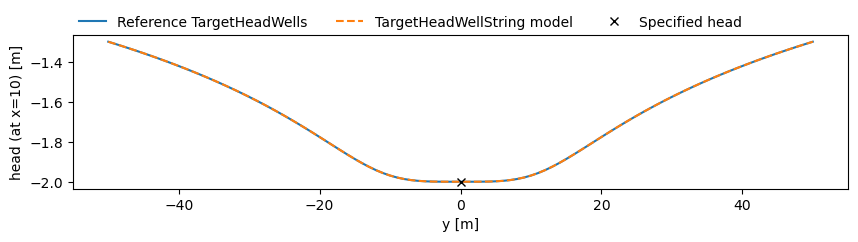

In [31]:
y = np.linspace(-50, 50, 101)
x = ws.xcp * np.ones_like(y)
href = mlref4.headalongline(x, y)
h2 = ml2.headalongline(x, y)

ilay = 0
plt.figure(figsize=(10, 2))
plt.plot(y, href[ilay], label="Reference TargetHeadWells")
plt.plot(y, h2[ilay], "--", label="TargetHeadWellString model")
plt.plot(ws.ycp, ws.hcp, "kx", label="Specified head")
plt.ylabel("head (at x=10) [m]")
plt.xlabel("y [m]")
plt.legend(loc=(0, 1), frameon=False, ncol=3);

Compare discharges

In [32]:
# 2 TargetHeadWells
wh1.discharge(), wh2.discharge()

(array([351.90537223]), array([351.90536043]))

In [33]:
# TargetHeadWellString model
ws.discharge_per_well()

array([[351.90536633, 351.90536633]])

Compare heads inside the well

In [34]:
# 2 TargetHeadwells
wh1.headinside(), wh2.headinside()

(array([-3.28956793]), array([-3.28956788]))

In [35]:
# TargetHeadWellString
ws.headinside(), ws.wlist[0].headinside(), ws.wlist[1].headinside()

(np.float64(-3.2895679095614794), array([-3.28956791]), array([-3.28956791]))

## Multi-layer example

An example of a TargetHeadWellString in a multi-layer model.

In [36]:
# model parameters
kh = [5, 10, 20]  # m/day

c = [1000.0, 100.0, 1.0]  # resistance leaky layers in days

ztop = 0.0  # surface elevation
zbot = -50.0  # bottom elevation of the model

z = [1.0, ztop, -10, -15, -25, -26, zbot]
kaq = np.array(kh)
c = np.array(c)

# point at which head is specified
xcp = 10.0
ycp = 0.0
hcp = -2.0  # specified head at (xc, yc)
lcp = 1 # layer

Create a multi-layer model with two TargetHeadWells.

In [37]:
mlref5 = tml.ModelMaq(kaq=kaq, c=c, z=z, topboundary="semi", hstar=0)
wh1 = tml.TargetHeadWell(
    mlref5, 0, -10, rw=0.1, layers=[0, 1, 2], hcp=hcp, xcp=xcp, ycp=ycp, lcp=lcp
)
wh2 = tml.TargetHeadWell(
    mlref5, 0, 10, rw=0.1, layers=[0, 1, 2], hcp=hcp, xcp=xcp, ycp=ycp - 1e-6, lcp=lcp
)  # nudge control pt to avoid singular matrix in solve
mlref5.solve()

Number of elements, Number of equations: 3 , 6
..
solution complete


Create a model with a TargetHeadWellString.

In [38]:
ml3 = tml.ModelMaq(kaq=kaq, c=c, z=z, topboundary="semi", hstar=0)
ws = tml.TargetHeadWellString(
    ml3, xy=[(0, -10), (0, 10)], rw=0.1, layers=[0, 1, 2], hcp=hcp, xcp=xcp, ycp=ycp, lcp=lcp
)
ml3.solve()

Number of elements, Number of equations: 2 , 6
.
solution complete


Plot the head contours in the reference model and the TargetHeadWellString model.

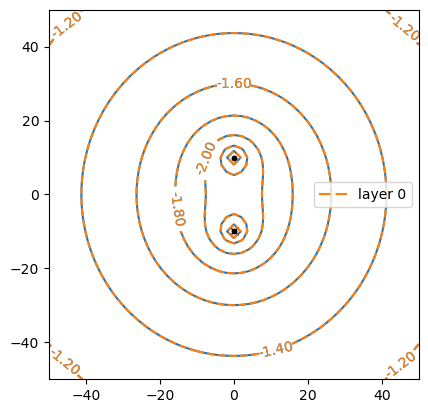

In [39]:
ilay = 0
levels = [-2.4, -2.2, -2.0, -1.8, -1.6, -1.4, -1.2]
mlref5.plots.contour(
    win=(-50, 50, -50, 50),
    ngr=51,
    levels=levels,
    decimals=2,
    layers=[ilay],
)
plt.plot(w1.xc, w1.yc, "kx")
ml3.plots.contour(
    win=(-50, 50, -50, 50),
    ngr=51,
    levels=levels,
    decimals=2,
    layers=[ilay],
    newfig=False,
    linestyles="dashed",
    color="C1",
);

Plot the head along y in the reference model and the TargetHeadWellString model.

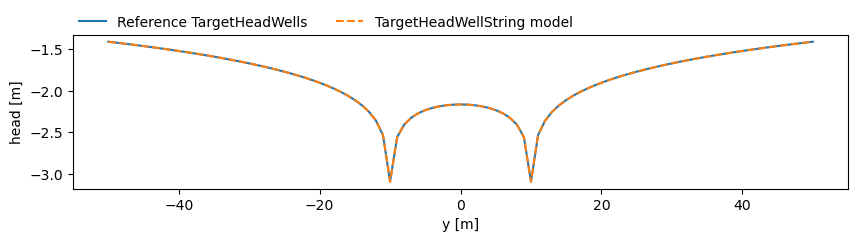

In [40]:
y = np.linspace(-50, 50, 101)
x = np.zeros_like(y)
href5 = mlref5.headalongline(x, y)
h3 = ml3.headalongline(x, y)

ilay = 1
plt.figure(figsize=(10, 2))
plt.plot(y, href5[ilay], label="Reference TargetHeadWells")
plt.plot(y, h3[ilay], "--", label="TargetHeadWellString model")
plt.ylabel("head [m]")
plt.xlabel("y [m]")
plt.legend(loc=(0, 1), frameon=False, ncol=3);

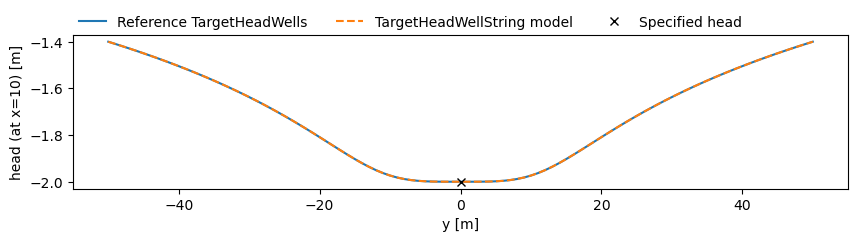

In [41]:
y = np.linspace(-50, 50, 101)
x = ws.xcp * np.ones_like(y)
href5 = mlref5.headalongline(x, y)
h3 = ml3.headalongline(x, y)

ilay = lcp
plt.figure(figsize=(10, 2))
plt.plot(y, href5[ilay], label="Reference TargetHeadWells")
plt.plot(y, h3[ilay], "--", label="TargetHeadWellString model")
plt.plot(ws.ycp, ws.hcp, "kx", label="Specified head")
plt.ylabel("head (at x=10) [m]")
plt.xlabel("y [m]")
plt.legend(loc=(0, 1), frameon=False, ncol=3);

Compare discharges

In [42]:
# 2 TargetHeadWells
wh1.discharge(), wh2.discharge()

(array([ 78.6860837 , 149.29528524, 716.30767807]),
 array([ 78.6860861 , 149.29529004, 716.30770112]))

In [43]:
# TargetHeadWellString, transposed to compare to above
ws.discharge_per_well().T

array([[ 78.6860849 , 149.29528764, 716.30768959],
       [ 78.6860849 , 149.29528764, 716.30768959]])

Compare heads inside the well

In [44]:
# Separate wells
wh1.headinside(), wh2.headinside()

(array([-3.09424292, -3.09424292, -3.09424292]),
 array([-3.09424296, -3.09424296, -3.09424296]))

In [45]:
# TargetHeadWellString
ws.wlist[0].headinside(), ws.wlist[1].headinside()

(array([-3.09424294, -3.09424294, -3.09424294]),
 array([-3.09424294, -3.09424294, -3.09424294]))

Compare heads at specified point

In [46]:
# 2 TargetHeadWells
mlref5.head(xcp, ycp)

array([-1.94106669, -2.        , -2.00047328])

In [47]:
# TargetHeadWellString
ml3.head(xcp, ycp)

array([-1.94106669, -2.        , -2.00047328])

### Different layers per well

The WellString elements allow the specification of different layers per well, as shown
in the example below.

In [48]:
ml4 = tml.ModelMaq(kaq=kaq, c=c, z=z, topboundary="semi", hstar=0)
ws = tml.TargetHeadWellString(
    ml4, xy=[(0, -10), (0, 10)], rw=0.1, layers=[(1,), (2,)], hcp=-1, xcp=10, ycp=0
)
ml4.solve()

Number of elements, Number of equations: 2 , 2
.
solution complete


Plot the wells in a cross-section.

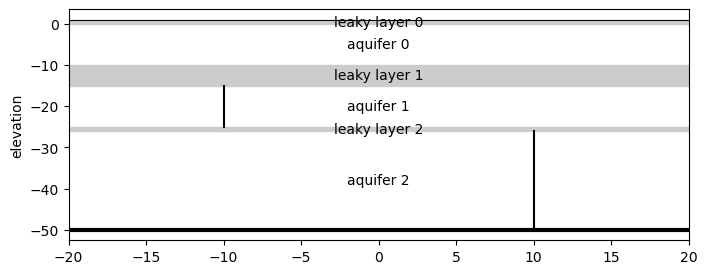

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ml4.plots.xsection(xy=[(0, 20), (0, -20)], labels=True, ax=ax)
for w in ws.wlist:
    for ilay in w.layers:
        ax.plot([w.yc, w.yc], [ml4.aq.zaqtop[ilay], ml4.aq.zaqbot[ilay]], "k-")

Plot a cross section of the head along y, showing all layers, and showing that the head
in layer 0 runs through -1, the head we specified in the TargetHeadWellString.

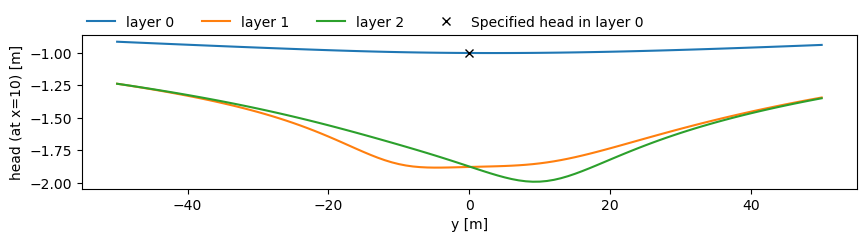

In [50]:
y = np.linspace(-50, 50, 101)
x = ws.xcp * np.ones_like(y)
h4 = ml4.headalongline(x, y)

ilay = 0
plt.figure(figsize=(10, 2))
for ilay in range(ml4.aq.naq):
    plt.plot(y, h4[ilay], "-", label=f"layer {ilay}")
plt.plot(ws.ycp, ws.hcp, "kx", label="Specified head in layer 0")
plt.ylabel("head (at x=10) [m]")
plt.xlabel("y [m]")
plt.legend(loc=(0, 1), frameon=False, ncol=4);

Get total well discharge per layer

In [51]:
ws.discharge()

array([   0.        ,  319.12051516, 1382.45288111])

Or per well, per layer

In [52]:
ws.discharge_per_well()  # shape : (nlay, nwells)

array([[   0.        ,    0.        ],
       [ 319.12051516,    0.        ],
       [   0.        , 1382.45288111]])

Show that head inside the wells is equal:

In [53]:
ws.wlist[0].headinside(), ws.wlist[1].headinside()

(array([-4.08198052]), array([-4.08198052]))

The `TargetHeadWellString` element also has a `headinside()` method that returns a
single value (since the head inside must be equal).

In [54]:
ws.headinside()

np.float64(-4.081980524341772)

### Test with first well screened in two layers

In [63]:
lcp = 1
ml5 = tml.ModelMaq(kaq=kaq, c=c, z=z, topboundary="semi", hstar=0)
ws = tml.TargetHeadWellString(
    ml5, xy=[(0, -10), (0, 10)], rw=0.1, layers=[(1,), (2,)], res=0.0, hcp=-1, xcp=10, ycp=0, lcp=lcp
)
ml5.solve()

Number of elements, Number of equations: 2 , 2
.
solution complete


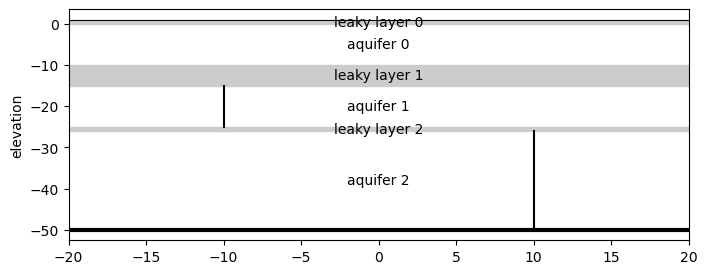

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ml5.plots.xsection(xy=[(0, 20), (0, -20)], labels=True, ax=ax)
for w in ws.wlist:
    for ilay in w.layers:
        ax.plot([w.yc, w.yc], [ml5.aq.zaqtop[ilay], ml5.aq.zaqbot[ilay]], "k-")

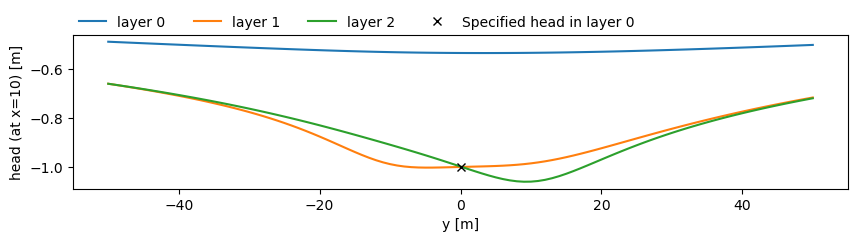

In [65]:
y = np.linspace(-50, 50, 101)
x = ws.xcp * np.ones_like(y)
h5 = ml5.headalongline(x, y)

ilay = lcp
plt.figure(figsize=(10, 2))
for ilay in range(ml5.aq.naq):
    plt.plot(y, h5[ilay], "-", label=f"layer {ilay}")
plt.plot(ws.ycp, ws.hcp, "kx", label="Specified head in layer 0")
plt.ylabel("head (at x=10) [m]")
plt.xlabel("y [m]")
plt.legend(loc=(0, 1), frameon=False, ncol=4);

In [66]:
ws.wlist[0].headinside(), ws.wlist[1].headinside()

(array([-2.17364972]), array([-2.17364972]))

In [67]:
ws.headinside()

np.float64(-2.1736497183130266)

In [69]:
ml5.head(xcp, ycp)

array([-0.5324988 , -1.        , -0.99826439])

### HeadWellString with resistance

In [76]:
ml = tml.ModelMaq(kaq=kaq, c=c, z=z, topboundary="semi", hstar=0)
hws = tml.HeadWellString(ml, xy=[(0, -10), (0, 10)], rw=0.1, res=0.1, 
                         layers=[0], hw=-2)
ml.solve()

Number of elements, Number of equations: 2 , 2
.
solution complete


In [77]:
hws.headinside()

np.float64(-3.206342594640146)

In [78]:
hws.wlist[0].headinside(), hws.wlist[1].headinside()

(array([-3.20634259]), array([-3.20634259]))

### TargetHeadWellString with resistance

In [84]:
lcp = 1
ml = tml.ModelMaq(kaq=kaq, c=c, z=z, topboundary="semi", hstar=0)
thw = tml.TargetHeadWellString(
    ml, xy=[(0, -10), (0, 10)], rw=0.1, layers=[(1,), (2,)], res=0.01, hcp=-1, xcp=10, ycp=0, lcp=lcp
)
ml.solve()

Number of elements, Number of equations: 2 , 2
.
solution complete


In [85]:
thw.headinside()

np.float64(-2.4441037668401244)

In [86]:
thw.wlist[0].headinside(), thw.wlist[1].headinside()

(array([-2.44410377]), array([-2.66182733]))